In [1]:
from loracraft.metrics import *
import glob
import numpy as np 
import json
import wandb
from loracraft.api import log_images, query_runs, get_images_from_run
import matplotlib.pyplot as plt



In [2]:
with open('lora_db.json', 'r') as f:
    lora_db = json.load(f)

In [48]:
trigger_lora = {}
categories = []
for lora in lora_db:
    trigger_lora[lora_db[lora]['triggers'][0]] = [lora]
    if lora_db[lora]['category'] not in categories:
        categories.append(lora_db[lora]['category'])

In [49]:
categories

['Character', 'Style', 'Concept', 'Clothing', 'Buildings']

In [4]:
trigger_lora

{'BJ_Sewing_doll': ['SewingDoll'],
 'cinematicpainting': ['CinematicPainting'],
 'pixar style': ['PixarXL'],
 'ral-friedegg': ['FriedEgg'],
 '': ['Details'],
 'cyborg': ['FacelessCyborgs'],
 'drawix6': ['Drawing'],
 'airpods_max ': ['AirPodsMax'],
 'Isometric_Setting': ['Isometric'],
 'vintage_p_style': ['VintagePortrait'],
 'Costume ShoshiZohar': ['SillyCostume'],
 'symmetrical': ['Symmetrical'],
 'ral-feathercoat': ['Federkleid']}

In [74]:

prompts = []
with open ("all_configs_with_0_loras.json", 'r') as f:
    configs = json.load(f)

In [75]:
for config in configs:
   if config['prompts'] not in prompts:
       prompts.append(config['prompts'])

In [76]:
prompts

[['ral-feathercoat'],
 ['drawix6'],
 ['pixar style'],
 ['Costume ShoshiZohar'],
 ['cyborg'],
 ['cinematicpainting'],
 ['BJ_Sewing_doll'],
 ['symmetrical'],
 ['Isometric_Setting'],
 ['vintage_p_style'],
 ['ral-friedegg'],
 ['airpods_max ']]

In [8]:
wandb.login()


Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: vfhernandes. Use `wandb login --relogin` to force relogin


True

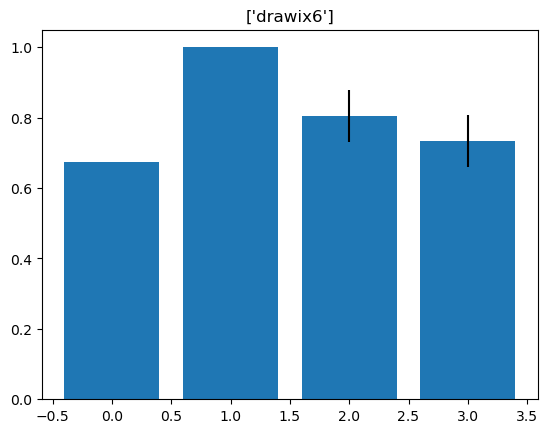

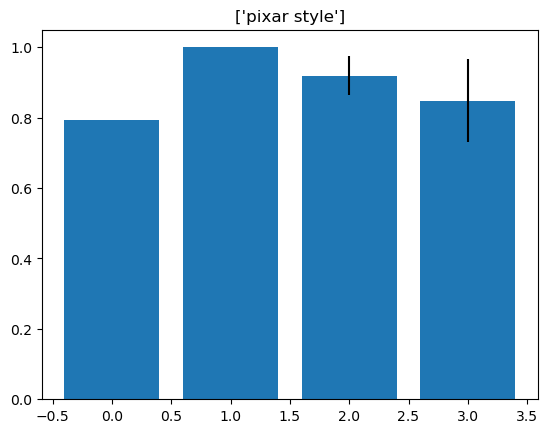

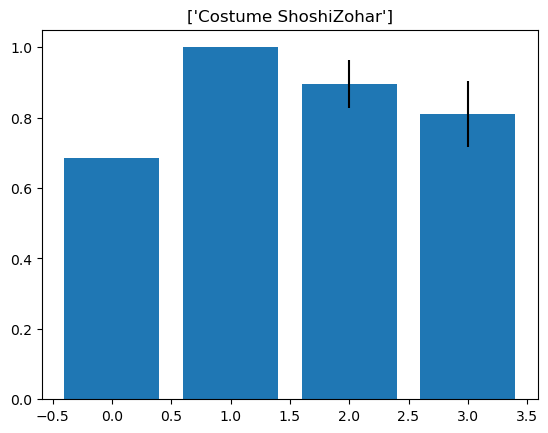

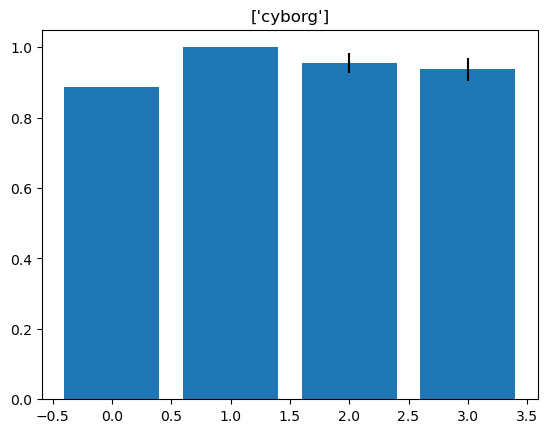

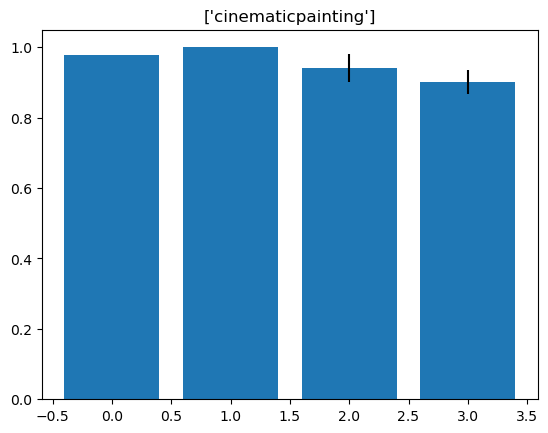

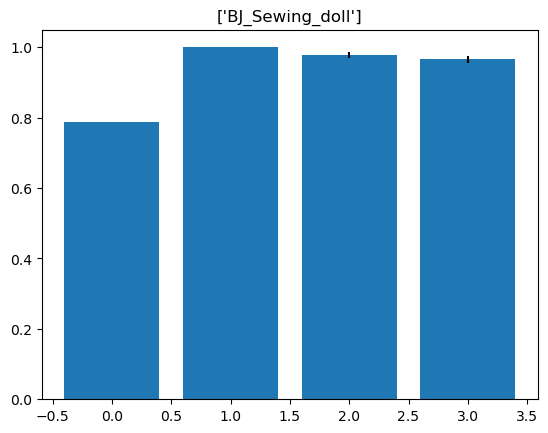

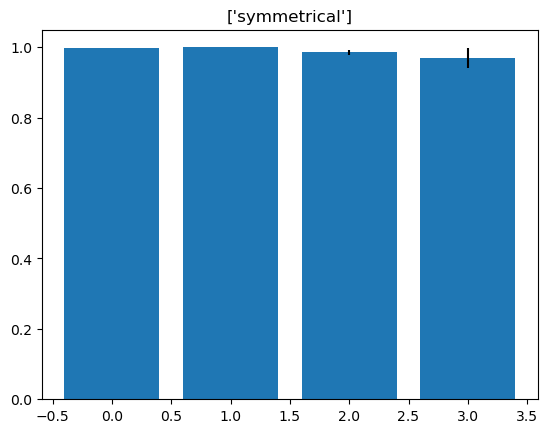

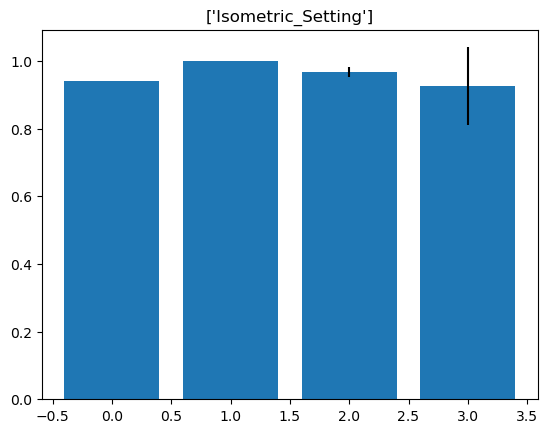

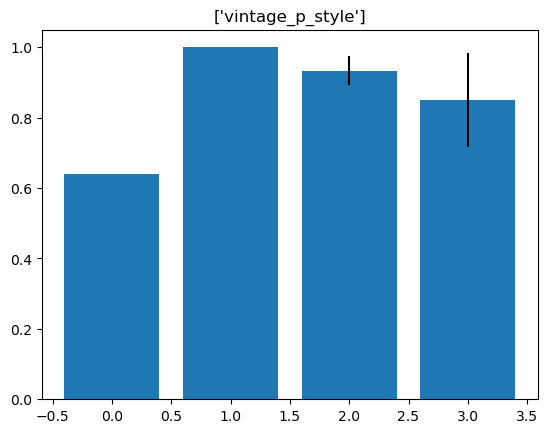

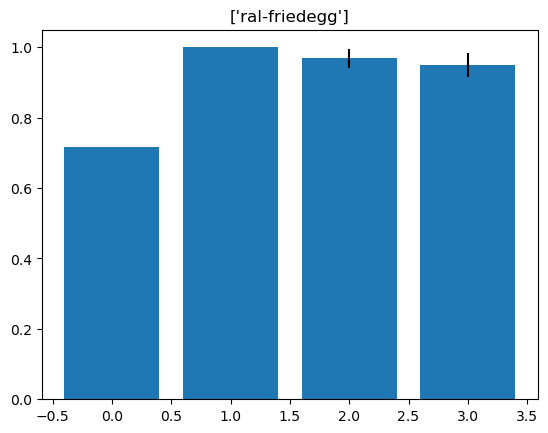

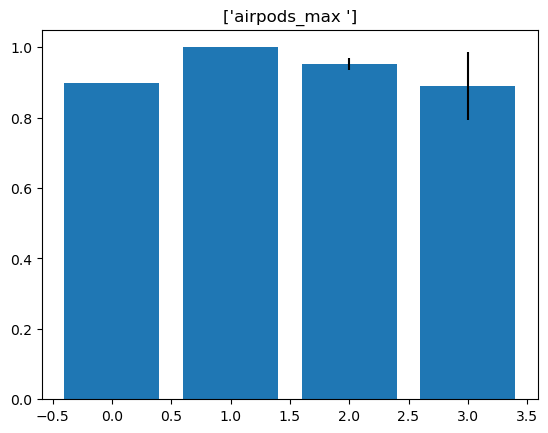

In [37]:

max_loras = 3
scores_all = np.zeros((len(prompts), max_loras+1))

k = 0


for prompt_index, prompt in enumerate(prompts):

    
    
    scores = {}
    for i in range(max_loras+1):
        scores[i] = []
    
    runs = query_runs({"prompts": prompt})
    imgs = [get_images_from_run(run)  for run in runs]
    configs = [run.config  for run in runs]

    max_weights = 0
    for config in configs:
        max_weights = len(config['weights']) if len(config['weights']) > max_weights else max_weights

    if max_weights == max_loras:
        imgs_ = []
        configs_ = []
        for index, img in enumerate(imgs):
            if len(img):
                imgs_.append(img)
                configs_.append(configs[index])

        imgs = imgs_
        configs = configs_



        for index, config in enumerate(configs):
            if config['loras'] == trigger_lora[prompt[0]]:
                reference_index = index
                break

        for index, img in enumerate(imgs):
            k += 1

            clip = clip_score(imgs[reference_index], img)
            scores[len(configs[index]['loras'])].append(clip)


        avgs = []
        stds = []
        for i in range(max_loras+1):
            avgs.append(np.average(scores[i]))
            stds.append(np.std(scores[i]))

        scores_all[prompt_index] = avgs
        
        plt.bar(np.arange(max_loras+1), avgs, yerr = stds)
        plt.title(prompt)
        plt.show()
        plt.close()


<BarContainer object of 4 artists>

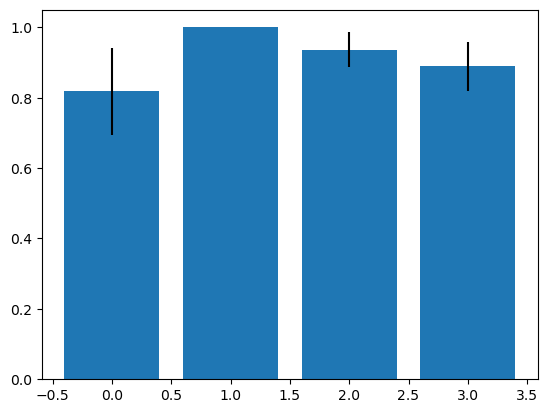

In [41]:


plt.bar(np.arange(4), 
        np.average(scores_all, axis = 0), 
        yerr = np.std(scores_all, axis =0))

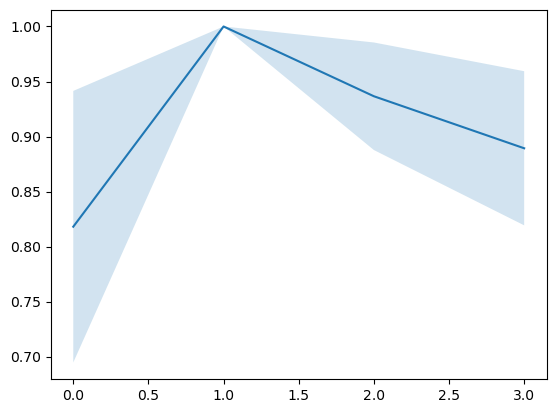

In [50]:
avgs_all = np.average(scores_all[1:], axis = 0)
stds_all = np.std(scores_all[1:], axis = 0)

plt.plot(np.arange(4), avgs_all)
plt.fill_between(np.arange(4), avgs_all+stds_all, avgs_all-stds_all, alpha = 0.2)

In [102]:

max_loras = 3
scores_all = np.zeros((len(prompts), max_loras+1))


for prompt_index, prompt in enumerate(prompts):
    
    scores = {}
    for i in range(max_loras+1):
        scores[i] = []
    
    runs = query_runs({"prompts": prompt})
    imgs = [get_images_from_run(run)  for run in runs]
    configs = [run.config  for run in runs]


    for index, config in enumerate(configs):
        if config['loras'] == trigger_lora[prompt[0]]:
            reference_index = index
            break

    reference_img = imgs[reference_index]

    imgs_ = []
    configs_ = []

    for config_index, config in enumerate(configs):
        if len(config['loras']) == 0:     
            print(imgs[config_index])         
            imgs_.append(imgs[config_index])
            configs_.append(config)  
        categories = []
        for lora in config['loras']:
            categories.append(lora_db[lora]['category'])
        if len(np.unique(categories)) == 1:
            imgs_.append(imgs[config_index])
            configs_.append(config)

    imgs = imgs_ 
    configs = configs_

    for config in configs:
        print(config)

    if len(imgs):
        print(imgs)

        for index, img in enumerate(imgs):
            clip = clip_score(reference_img, img)
            scores[len(configs[index]['loras'])].append(clip)

        print(scores)




        # avgs = []
        # stds = []
        # for i in range(max_loras+1):
        #     avgs.append(np.average(scores[i]))
        #     stds.append(np.std(scores[i]))

        # scores_all[prompt_index] = avgs
        
        # plt.bar(np.arange(max_loras+1), avgs, yerr = stds)
        # plt.title(prompt)
        # plt.show()
        # plt.close()


[]
[]
[<PIL.PngImagePlugin.PngImageFile image mode=RGB size=512x512 at 0x16665FB80>]
{'seed': 42, 'loras': [], 'trials': 1, 'prompts': ['ral-feathercoat'], 'weights': [1, 1], 'images_path': './output/no-loras/', 'pipeline_kwargs': {'guidance_scale': 0, 'num_inference_steps': 1}}
{'seed': 42, 'loras': [], 'trials': 1, 'prompts': ['ral-feathercoat'], 'weights': [1, 1], 'images_path': './output/no-loras/', 'pipeline_kwargs': {'guidance_scale': 0, 'num_inference_steps': 1}}
{'seed': 42, 'loras': ['Federkleid'], 'trials': 1, 'prompts': ['ral-feathercoat'], 'weights': [1, 1], 'images_path': './output/federkleid/', 'pipeline_kwargs': {'guidance_scale': 0, 'num_inference_steps': 1}}
{'seed': 42, 'loras': [], 'trials': 1, 'prompts': ['ral-feathercoat'], 'weights': [1, 1], 'images_path': './output/no-loras/', 'pipeline_kwargs': {'guidance_scale': 0, 'num_inference_steps': 1}}
{'seed': 42, 'loras': ['Federkleid', 'SillyCostume'], 'trials': 1, 'prompts': ['ral-feathercoat'], 'weights': [1, 1], 'im

IndexError: index 0 is out of bounds for dimension 0 with size 0

In [96]:
configs

[{'seed': 42,
  'loras': ['PixarXL', 'PixarXL', 'Details'],
  'trials': 1,
  'prompts': ['pixar style'],
  'version': 1,
  'weights': [1, 1, 1],
  'images_path': './output/pixarxl-pixarxl-details/',
  'pipeline_kwargs': {'guidance_scale': 0, 'num_inference_steps': 1}},
 {'seed': 42,
  'loras': ['PixarXL', 'CinematicPainting', 'Drawing'],
  'trials': 1,
  'prompts': ['pixar style'],
  'version': 1,
  'weights': [1, 1, 1],
  'images_path': './output/pixarxl-cinematicpainting-drawing/',
  'pipeline_kwargs': {'guidance_scale': 0, 'num_inference_steps': 1}},
 {'seed': 42,
  'loras': ['PixarXL', 'CinematicPainting', 'PixarXL'],
  'trials': 1,
  'prompts': ['pixar style'],
  'version': 1,
  'weights': [1, 1, 1],
  'images_path': './output/pixarxl-cinematicpainting-pixarxl/',
  'pipeline_kwargs': {'guidance_scale': 0, 'num_inference_steps': 1}},
 {'seed': 42,
  'loras': ['PixarXL'],
  'trials': 1,
  'prompts': ['pixar style'],
  'weights': [1, 1],
  'images_path': './output/pixarxl/',
  'pipel

In [81]:
for lora in config['loras']:
    print(lora_db[lora]['category'])

Clothing
Style
Clothing


In [60]:
p

<Runs ppierzc/loracraft>